First, install Rust in the same environment as the transformers library uses tokenizers built in Rust. 
* paste the following line in a new terminal and hit enter: 
 ```curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh```

* Then install transformers and datasets


In [11]:
#!pip install transformers datasets
PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

In [12]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import time

In [13]:
trec_data = load_dataset('trec', split='train[:1000]')
trec_data

Found cached dataset trec (/Users/dipakrimal/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2)


Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 1000
})

In [14]:
trec_data[0]

{'text': 'How did serfdom develop in and then leave Russia ?',
 'coarse_label': 2,
 'fine_label': 26}

In [15]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# take the first 64 rows of the trec data
text = trec_data['text'][:64]
# tokenize text using the BERT tokenizer
tokens = tokenizer(
    text, max_length=128,
    truncation=True, padding=True,
    return_tensors='pt'
)


In [17]:
%%timeit
model(**tokens)

543 ms ± 5.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
device = 'mps'
model.to(device)
tokens.to(device)
device

'mps'

In [19]:
%%timeit
model(**tokens)


228 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
from time import time

reruns = 10
b = 8

# start with CPU test
device = torch.device('cpu')
model.to(device)

cpu_times = []

for i in range(2, b):
    text = trec_data['text'][:2**i]
    tokens = tokenizer(
        text, max_length=512,
        truncation=True, padding=True,
        return_tensors='pt'
    )
    tot_time = 0
    for _ in range(reruns):
        t0 = time()
        model(**tokens)
        tot_time += time()-t0
    cpu_times.append(tot_time/reruns)

# then GPU test
device = torch.device('mps')
model.to(device)

mps_times = []

for i in range(2, b):
    text = trec_data['text'][:2**i]
    tokens = tokenizer(
        text, max_length=512,
        truncation=True, padding=True,
        return_tensors='pt'
    ).to(device)
    tot_time = 0
    for _ in range(reruns):
        t0 = time()
        model(**tokens)
        tot_time += time()-t0
    mps_times.append(tot_time/reruns)

In [41]:
import matplotlib.pyplot as plt

In [42]:
batch_sizes = [2**i for i in range(2, b)]

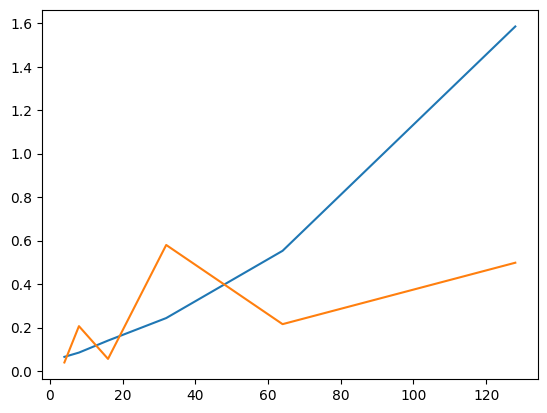

In [43]:
plt.plot(batch_sizes, cpu_times, label='CPU')
plt.plot(batch_sizes, mps_times, label='GPU')
plt.show()

In [ ]:
# My 8 GB M1 mac quickly out of memory so I could not fully test if the acceleration is significant. 